# People Detection & Crowd Sizing with YOLOv8

In [ ]:
!pip install -q optuna optuna_integration
!pip install -q kagglehub
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import shutil
from pathlib import Path
from typing import Dict, Tuple
import yaml
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO
import kagglehub
import optuna
from optuna.integration import TFKerasPruningCallback, PyTorchLightningPruningCallback
from PIL import Image
# Reproducibility
random.seed(42)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Download dataset

In [ ]:
import shutil
import os

folder_to_delete = 'people_detection'
if os.path.exists(folder_to_delete):
    shutil.rmtree(folder_to_delete)
    print(f"Folder '{folder_to_delete}' and its contents deleted successfully.")
else:
    print(f"Folder '{folder_to_delete}' does not exist.")

Folder 'people_detection' does not exist.


In [ ]:
# Download latest version
download_path = kagglehub.dataset_download("adilshamim8/people-detection")

print("Path to dataset files:", download_path)

Using Colab cache for faster access to the 'people-detection' dataset.
Path to dataset files: /kaggle/input/people-detection


In [ ]:
root_path = Path.cwd()
print("Project root:", root_path)

Project root: /content


In [ ]:
project_root = root_path / 'people_detection'
data_path = project_root / 'data'
raw_data_path = data_path / 'raw'
processed_root = data_path / 'processed'
models_dir = project_root / 'models'
pred_dir = models_dir / 'predictions'

project_root.mkdir(parents=True, exist_ok=True)
data_path.mkdir(parents=True, exist_ok=True)
raw_data_path.mkdir(parents=True, exist_ok=True)
processed_root.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)
pred_dir.mkdir(parents=True, exist_ok=True)

## Load data

### copy downloaded data to raw data path

In [ ]:
target_splits = ['train', 'valid', 'test']

for split_name in target_splits:
    source_dir = Path(download_path) / split_name / split_name # Corrected to include nested split_name
    destination_dir = raw_data_path / split_name

    if source_dir.exists():
        # Remove existing destination directory to ensure a fresh copy
        if destination_dir.exists():
            shutil.rmtree(destination_dir)
            print(f"Removed existing '{destination_dir}' for a fresh copy.")

        shutil.copytree(source_dir, destination_dir)
        print(f"Copied '{source_dir}' to '{destination_dir}'.")
    else:
        print(f"Source directory '{source_dir}' does not exist. Skipping.")

print("Copy operation for specified splits complete.")

Copied '/kaggle/input/people-detection/train/train' to '/content/people_detection/data/raw/train'.
Copied '/kaggle/input/people-detection/valid/valid' to '/content/people_detection/data/raw/valid'.
Copied '/kaggle/input/people-detection/test/test' to '/content/people_detection/data/raw/test'.
Copy operation for specified splits complete.


### Inspect annotation schema (CSV head).

In [ ]:
def load_annotations(split: str) -> pd.DataFrame:
    """Load annotation CSV for a split and validate expected columns."""
    csv_path = raw_data_path / split / '_annotations.csv'
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing annotations for split '{split}' at {csv_path}")
    df = pd.read_csv(csv_path)

    # Normalize filenames and make sure each annotated image actually exists on disk.
    df['filename'] = df['filename'].astype(str).str.strip().apply(lambda name: Path(name).name)
    missing_files = [
        name for name in df['filename'].unique()
        if not (raw_data_path / split / name).exists()
    ]
    if missing_files:
        sample = ', '.join(missing_files[:5])
        raise FileNotFoundError(
            f"{len(missing_files)} annotated files missing in split '{split}': {sample}"
        )
    return df

In [ ]:
# def load_annotations(split: str) -> pd.DataFrame:
#     """Load annotation CSV for a split and validate expected columns."""
#     csv_path = raw_data_path / split / '_annotations.csv'
#     if not csv_path.exists():
#         raise FileNotFoundError(f"Missing annotations for split '{split}' at {csv_path}")
#     df = pd.read_csv(csv_path)
#     expected_cols = {'filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'}
#     if not expected_cols.issubset(set(df.columns)):
#         raise ValueError(f"Unexpected columns in {csv_path}: {df.columns}")
#     return df

### Count images per split.

In [ ]:
splits = ['train', 'valid', 'test']
ann_dfs: Dict[str, pd.DataFrame] = {}
rows = []
for split in splits:
    df = load_annotations(split)
    ann_dfs[split] = df
    unique_imgs = df['filename'].nunique()
    rows.append({'split': split, 'images': unique_imgs, 'boxes': len(df)})

stats_df = pd.DataFrame(rows)
print(stats_df)


   split  images   boxes
0  train   13278  100082
1  valid    1370   10683
2   test     738    2783


In [ ]:
print("Train set annotation")
display(ann_dfs['train'].head())

Train set annotation


filename  width  height   class  \
0  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
1  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
2  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
3  004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333  person   
4  004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333  person   

   xmin  ymin  xmax  ymax  
0   219    98   269   283  
1   114   124   155   263  
2    43   139    98   340  
3   145   118   229   333  
4   285   105   349   329

### extract subset of data for training

In [ ]:
# SUBSET_FRAC = 0.05  # 5% of training images
# train_df = ann_dfs['train']
# filenames = train_df['filename'].unique().tolist()
# if len(filenames) == 0:
#     raise ValueError('No training images found to subsample.')
# subset_n = max(1, int(len(filenames) * SUBSET_FRAC))
# subset_files = random.sample(filenames, k=subset_n)
# ann_dfs['train'] = train_df[train_df['filename'].isin(subset_files)].copy()

# print(f"Train subset: {len(subset_files)} of {len(filenames)} images (~{SUBSET_FRAC*100:.1f}%).")
# print(f"Boxes in subset: {len(ann_dfs['train'])}")


In [ ]:
SUBSET_FRAC = 0.30  # 5% of training images
train_df = ann_dfs['train']
filenames = sorted(train_df['filename'].unique().tolist())
if len(filenames) == 0:
    raise ValueError('No training images found to subsample.')
subset_n = max(1, int(len(filenames) * SUBSET_FRAC))
subset_files = random.sample(filenames, k=subset_n)
subset_df = train_df[train_df['filename'].isin(subset_files)].copy()
subset_names = sorted(subset_df['filename'].unique().tolist())
if set(subset_names) != set(subset_files):
    raise ValueError('Subset annotation filenames do not line up with sampled files.')
missing_images = [
    name for name in subset_names
    if not (raw_data_path / 'train' / name).exists()
]
if missing_images:
    sample = ', '.join(missing_images[:5])
    raise FileNotFoundError(
        f"{len(missing_images)} subset images referenced in annotations are missing: {sample}"
    )

ann_dfs['train'] = subset_df

print(f"Train subset: {len(subset_files)} of {len(filenames)} images (~{SUBSET_FRAC*100:.1f}%).")
print(f"Boxes in subset: {len(subset_df)}")

Train subset: 3983 of 13278 images (~30.0%).
Boxes in subset: 29028


## Visualize Images

In [ ]:
def get_image_path(split: str, filename: str) -> Path:
    """Return image path for a given split and filename, raising if missing."""
    path = raw_data_path / split / filename
    if not path.exists():
        raise FileNotFoundError(f"Image {filename} not found in {split}")
    return path

In [ ]:
def draw_boxes(img_bgr: np.ndarray, boxes: np.ndarray, color=(0, 255, 0)) -> np.ndarray:
    """Draw bounding boxes on a BGR image and return the annotated copy."""
    img = img_bgr.copy()
    for xmin, ymin, xmax, ymax in boxes.astype(int):
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    return img

In [ ]:
def show_random_samples(df: pd.DataFrame, split: str, n: int = 5):
    """Display random labeled images from a split with their bounding boxes."""
    sample_files = random.sample(list(df['filename'].unique()), k=min(n, df['filename'].nunique()))
    fig, axes = plt.subplots(1, len(sample_files), figsize=(4*len(sample_files), 4))
    if len(sample_files) == 1:
        axes = [axes]
    for ax, fname in zip(axes, sample_files):
        subset = df[df['filename'] == fname]
        img_path = get_image_path(split, fname)
        img = cv2.imread(str(img_path))
        boxes = subset[['xmin', 'ymin', 'xmax', 'ymax']].values
        img_boxes = draw_boxes(img, boxes)
        ax.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(fname[:30] + ('...' if len(fname) > 30 else ''))
    plt.tight_layout()
    plt.show()




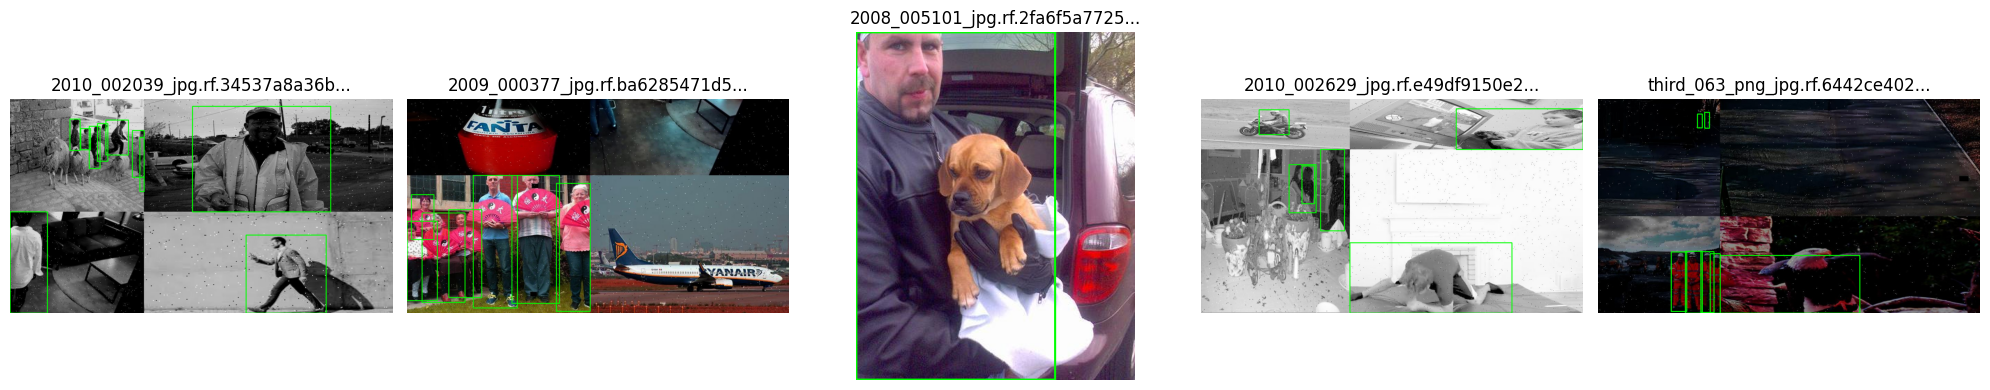

In [ ]:
show_random_samples(ann_dfs['train'], 'train', n=5)

## Preprocess
- convert CSV bboxes to YOLO format & organize splits
- Copy processed images into `data/processed/images/{train,val,test}`.
- Writes normalized labels in `labels/{split}`.
- Generates a `data.yaml` pointing to these splits.

In [ ]:
# ensure processed path is clean
def ensure_clean_dir(path: Path):
    """Remove a directory if it exists and recreate it empty."""
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

In [ ]:
split_alias = {'train': 'train', 'valid': 'val', 'test': 'test'}

images_root = processed_root / 'images'
labels_root = processed_root / 'labels'
ensure_clean_dir(images_root)
ensure_clean_dir(labels_root)

def convert_split(df: pd.DataFrame, split: str):
    """Copy images and write YOLO labels for a split using CSV annotations."""
    img_out = images_root / split_alias[split]
    lbl_out = labels_root / split_alias[split]
    img_out.mkdir(parents=True, exist_ok=True)
    lbl_out.mkdir(parents=True, exist_ok=True)

    for filename, group in tqdm(df.groupby('filename'), desc=f'Converting {split}'):
        img_path = get_image_path(split, filename)
        img = cv2.imread(str(img_path))
        if img is None:
            raise ValueError(f"Failed to read image {img_path}")
        h, w = img.shape[:2]
        lines = []
        for _, row in group.iterrows():
            x_center = ((row['xmin'] + row['xmax']) / 2.0) / w
            y_center = ((row['ymin'] + row['ymax']) / 2.0) / h
            box_w = (row['xmax'] - row['xmin']) / w
            box_h = (row['ymax'] - row['ymin']) / h
            lines.append(f"0 {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}")
        (lbl_out / f"{Path(filename).stem}.txt").write_text(''.join(lines))
        shutil.copy2(img_path, img_out / filename)




In [ ]:
for split, df in ann_dfs.items():
    convert_split(df, split)

print("Finished preprocessing. Processed data at:", processed_root)

Converting test: 100%|██████████| 738/738 [00:01<00:00, 440.98it/s]

Finished preprocessing. Processed data at: /content/people_detection/data/processed


In [ ]:
# Write data.yaml for YOLO training

data_yaml = {
    'train': str((images_root / 'train').resolve()),
    'val': str((images_root / 'val').resolve()),
    'test': str((images_root / 'test').resolve()),
    'nc': 1,
    'names': ['person'],
}

data_yaml_path = processed_root / 'data.yaml'
with open(data_yaml_path, 'w') as f:
    yaml.safe_dump(data_yaml, f)
print(data_yaml_path.read_text())


names:
- person
nc: 1
test: /content/people_detection/data/processed/images/test
train: /content/people_detection/data/processed/images/train
val: /content/people_detection/data/processed/images/val



## Display processed train images with boxes

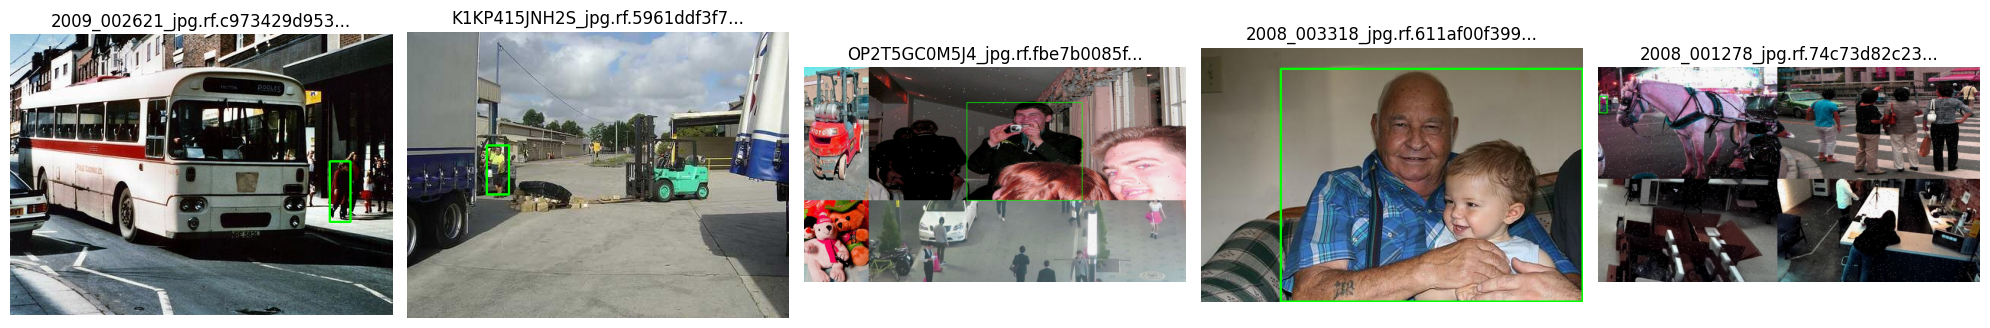

In [ ]:
def show_processed_samples(n: int = 5):
    """Display random processed train images with decoded YOLO boxes."""
    lbl_dir = labels_root / 'train'
    img_dir = images_root / 'train'
    files = list(img_dir.glob('*'))
    sample_files = random.sample(files, k=min(n, len(files)))
    fig, axes = plt.subplots(1, len(sample_files), figsize=(4*len(sample_files), 4))
    if len(sample_files) == 1:
        axes = [axes]
    for ax, img_path in zip(axes, sample_files):
        img = cv2.imread(str(img_path))
        lbl_path = lbl_dir / f"{img_path.stem}.txt"
        boxes = []
        if lbl_path.exists():
            for line in lbl_path.read_text().strip().splitlines():
                parts = line.split()
                if len(parts) < 5:
                    continue
                cls = parts[0]
                try:
                    x, y, w, h = map(float, parts[1:5])
                except ValueError:
                    continue
                h_img, w_img = img.shape[:2]
                xmin = int((x - w/2) * w_img)
                xmax = int((x + w/2) * w_img)
                ymin = int((y - h/2) * h_img)
                ymax = int((y + h/2) * h_img)
                boxes.append((xmin, ymin, xmax, ymax))
        img_boxes = draw_boxes(img, np.array(boxes)) if boxes else img
        ax.imshow(cv2.cvtColor(img_boxes, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(img_path.name[:30] + ('...' if len(img_path.name) > 30 else ''))
    plt.tight_layout()
    plt.show()

show_processed_samples(n=5)


## Train YOLOv8 Model
- define training parameters
- Implement random search for hyper-parameter tuning


### optuna objective function

In [ ]:
def objective(trial):
    # ----- Hyperparameter Sampling -----
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam", "AdamW"])
    lr0 = trial.suggest_float("lr0", 1e-4, 5e-2, log=True)
    lrf = trial.suggest_float("lrf", 0.05, 0.2)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 5e-4, log=True)
    patience = trial.suggest_int("patience", 5, 10)
    batch_size = trial.suggest_categorical("batch", [8, 16, 32])

    # ----- Train YOLO -----
    model = YOLO("yolov8m.pt")
    results = model.train(
        data=data_yaml_path,
        device=0,
        epochs=20,
        optimizer=optimizer,
        lr0=lr0,
        lrf=lrf,
        batch=batch_size,
        imgsz=640,
        weight_decay=weight_decay,
        patience=patience,
        project=project_root / 'optuna_runs',
        name=f"trial_{trial.number}"
    )

    # Extract validation loss (or mAP)
    val_results = model.val(data=data_yaml_path, imgsz=640, plots=True)
    metrics = val_results.results_dict

    # # Extract precision, recall and mAP after validation
    precision = metrics["metrics/precision(B)"]
    recall = metrics["metrics/recall(B)"]
    mAP50 = metrics["metrics/mAP50(B)"]
    mAP5095 = metrics["metrics/mAP50-95(B)"]

    print(f"Trial {trial.number}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"mAP50: {mAP50}")
    print(f"mAP5095: {mAP5095}")
    print("-" * 50)


    # Return the recall metric for Optuna to maximize
    return recall

### Initiate study

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)


[I 2025-11-22 11:22:43,501] A new study created in memory with name: no-name-93387dbb-f733-4730-91f2-c707a2b74fdb


Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/people_detection/data/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.016739783451433534, lrf=0.10588113464794105, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=trial_0, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True

[I 2025-11-22 11:43:56,975] Trial 0 finished with value: 0.4127009159252228 and parameters: {'optimizer': 'SGD', 'lr0': 0.016739783451433534, 'lrf': 0.10588113464794105, 'weight_decay': 0.00023023314558418578, 'patience': 7, 'batch': 32}. Best is trial 0 with value: 0.4127009159252228.


Trial 0
Precision: 0.47416976530502813
Recall: 0.4127009159252228
mAP50: 0.4083052784650258
mAP5095: 0.21144891310636743
--------------------------------------------------
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/people_detection/data/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0022519238571492117, lrf=0.1690835862409871, mask_ratio=4, max_det=300, mixup=0.0

[I 2025-11-22 12:29:06,303] Trial 1 finished with value: 0.6105238363383145 and parameters: {'optimizer': 'SGD', 'lr0': 0.0022519238571492117, 'lrf': 0.1690835862409871, 'weight_decay': 0.00029917995855244575, 'patience': 5, 'batch': 16}. Best is trial 1 with value: 0.6105238363383145.


Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/people_detection/data/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00012511885921942347, lrf=0.1478729905089868, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=trial_2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=T

[I 2025-11-22 13:23:05,533] Trial 2 finished with value: 0.6576642335766424 and parameters: {'optimizer': 'AdamW', 'lr0': 0.00012511885921942347, 'lrf': 0.1478729905089868, 'weight_decay': 7.279450483018332e-05, 'patience': 10, 'batch': 32}. Best is trial 2 with value: 0.6576642335766424.


Trial 2
Precision: 0.6629593827575851
Recall: 0.6576642335766424
mAP50: 0.6887796054693486
mAP5095: 0.4252415414959098
--------------------------------------------------
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/people_detection/data/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00031065215573557024, lrf=0.19805745140658165, mask_ratio=4, max_det=300, mixup=0.0

[I 2025-11-22 14:19:53,446] Trial 3 finished with value: 0.5671532846715328 and parameters: {'optimizer': 'Adam', 'lr0': 0.00031065215573557024, 'lrf': 0.19805745140658165, 'weight_decay': 1.0063293249154145e-05, 'patience': 7, 'batch': 16}. Best is trial 2 with value: 0.6576642335766424.


Trial 3
Precision: 0.6476632205501395
Recall: 0.5671532846715328
mAP50: 0.6129456441708413
mAP5095: 0.3609991965199998
--------------------------------------------------
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/people_detection/data/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002525256366735788, lrf=0.09871944060763269, mask_ratio=4, max_det=300, mixup=0.0,

[I 2025-11-22 15:15:00,857] Trial 4 finished with value: 0.6204379562043796 and parameters: {'optimizer': 'AdamW', 'lr0': 0.0002525256366735788, 'lrf': 0.09871944060763269, 'weight_decay': 2.2256433342423954e-05, 'patience': 7, 'batch': 32}. Best is trial 2 with value: 0.6576642335766424.


Trial 4
Precision: 0.6934819773240631
Recall: 0.6204379562043796
mAP50: 0.6789054459957451
mAP5095: 0.4061326222477667
--------------------------------------------------


In [ ]:

best = study.best_trial
print("Best hyperparameters:")
print(best)
print("Best validation loss:", study.best_value)


Best hyperparameters:
FrozenTrial(number=2, state=<TrialState.COMPLETE: 1>, values=[0.6576642335766424], datetime_start=datetime.datetime(2025, 11, 22, 12, 29, 6, 304179), datetime_complete=datetime.datetime(2025, 11, 22, 13, 23, 5, 532913), params={'optimizer': 'AdamW', 'lr0': 0.00012511885921942347, 'lrf': 0.1478729905089868, 'weight_decay': 7.279450483018332e-05, 'patience': 10, 'batch': 32}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('SGD', 'Adam', 'AdamW')), 'lr0': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'lrf': FloatDistribution(high=0.2, log=False, low=0.05, step=None), 'weight_decay': FloatDistribution(high=0.0005, log=True, low=1e-05, step=None), 'patience': IntDistribution(high=10, log=False, low=5, step=1), 'batch': CategoricalDistribution(choices=(8, 16, 32))}, trial_id=2, value=None)
Best validation loss: 0.6576642335766424


## Train final model with best parameters

In [ ]:

model = YOLO("yolov8m.pt")
final_results = model.train(
    data=data_yaml_path,
    device=0,
    epochs=20,
    optimizer=best.params["optimizer"],
    lr0=best.params["lr0"],
    lrf=best.params["lrf"],
    weight_decay=best.params["weight_decay"],
    patience=best.params["patience"],
    batch=best.params["batch"],
    imgsz=640,
    project=project_root / 'final_model',
    name="best_optuna_run"
)

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/people_detection/data/processed/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00012511885921942347, lrf=0.1478729905089868, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=best_optuna_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overla

## Visualization

In [ ]:
## load the best model
train_path = project_root / 'final_model/best_optuna_run'
model = YOLO(train_path / 'weights/best.pt')
metrics = model.val(data=data_yaml_path, imgsz=640, plots=True)

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 920.0±379.5 MB/s, size: 30.1 KB)
val: Scanning /content/people_detection/data/processed/labels/val.cache... 1370 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1370/1370 2.0Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 785, len(boxes) = 1370. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 86/86 2.9it/s 29.4s
                   all       1370       1370      0.663      0.658      0.689      0.425
Speed: 1.0ms preprocess, 16.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /conte

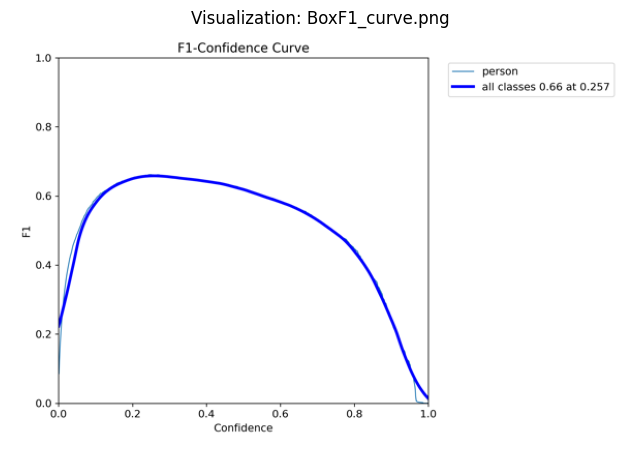

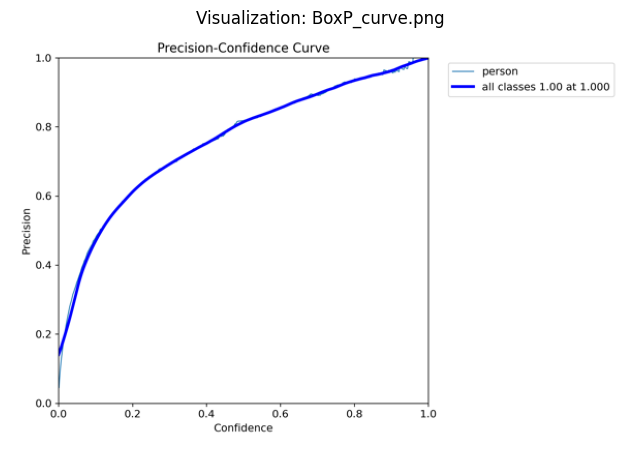

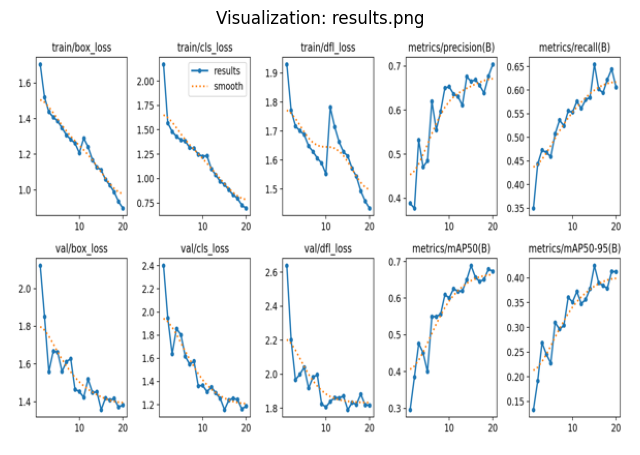

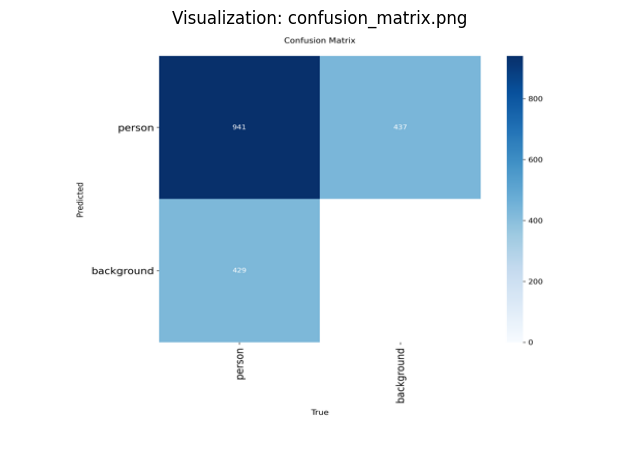

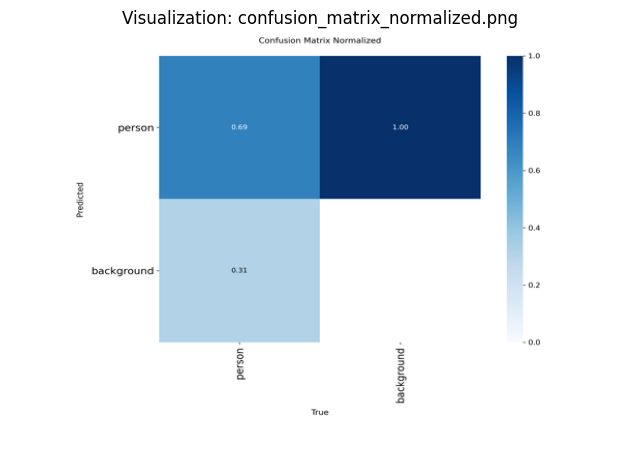

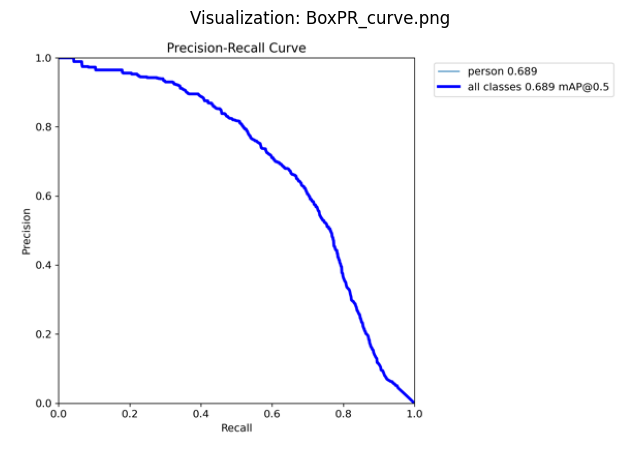

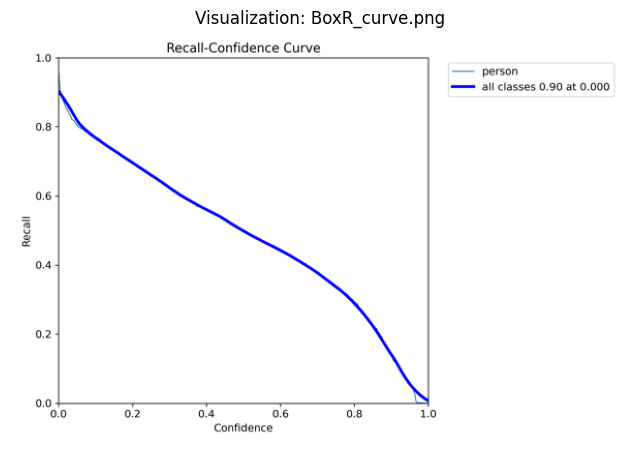

In [ ]:
# loop through result visualization images
png_files = [f for f in os.listdir(train_path) if f.endswith(".png")]

# Loop through each .png file and display it
for png_file in png_files:
    file_path = os.path.join(train_path, png_file)
    image = Image.open(file_path).resize((600, 400))
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Visualization: {png_file}")
    plt.show()

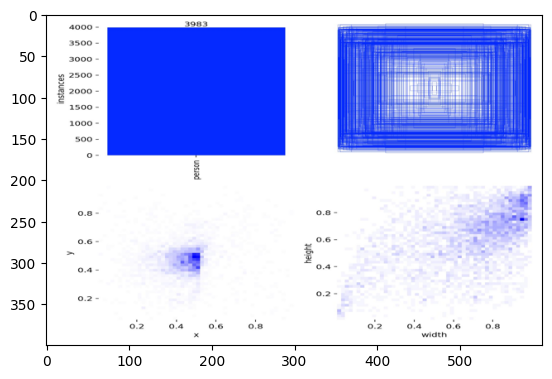

In [ ]:
# Show labels and correlogram diagrams
labels = Image.open(train_path / 'labels.jpg').resize((600,400))
plt.imshow(labels)

## Visualize prediction on test sets


image 1/1 /content/people_detection/data/processed/images/test/2011_007097_jpg.rf.84c2c6b26084305ccba516b935631294.jpg: 448x640 1 person, 312.8ms
Speed: 14.2ms preprocess, 312.8ms inference, 14.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/people_detection/data/processed/images/test/2008_002791_jpg.rf.2cd15827f5e67831f982fe1900a46b2d.jpg: 480x640 1 person, 53.1ms
Speed: 2.4ms preprocess, 53.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/people_detection/data/processed/images/test/2007_006317_jpg.rf.f88ba656f987e2550d96590175a8609f.jpg: 480x640 1 person, 27.7ms
Speed: 1.9ms preprocess, 27.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/people_detection/data/processed/images/test/2007_002403_jpg.rf.8b40f87340681fc1d303e7c2fee45cac.jpg: 480x640 1 person, 27.7ms
Speed: 1.9ms preprocess, 27.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/peop

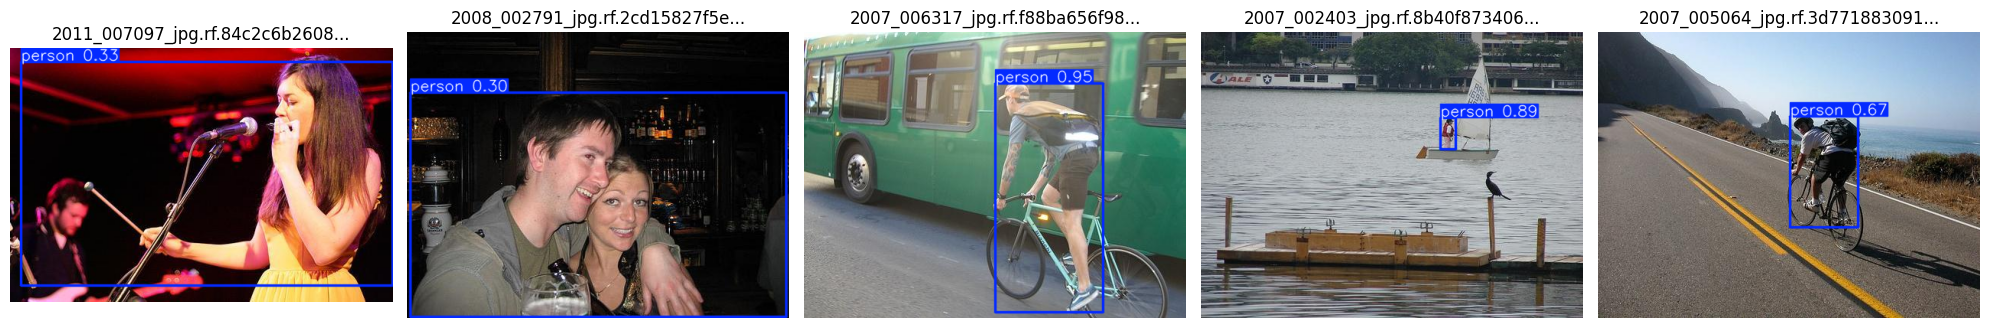

In [ ]:
test_image_dir = images_root / 'test'
test_image_files = list(test_image_dir.glob('*'))

if not test_image_files:
    print("No images found in the test directory.")
else:
    # Select a few random images from the test set
    num_samples = 5
    sample_test_images = random.sample(test_image_files, k=min(num_samples, len(test_image_files)))

    fig, axes = plt.subplots(1, len(sample_test_images), figsize=(4*len(sample_test_images), 4))
    if len(sample_test_images) == 1:
        axes = [axes]

    for ax, img_path in zip(axes, sample_test_images):

        results = model.predict(str(img_path))[0]

        # Annotate the image (results.plot() returns a BGR numpy array)
        annotated_img = results.plot()

        # Convert BGR to RGB for matplotlib display
        annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

        ax.imshow(annotated_img_rgb)
        ax.axis('off')
        ax.set_title(img_path.name[:30] + ('...' if len(img_path.name) > 30 else ''))

    plt.tight_layout()
    plt.show()

## Inference + crowd sizing on a sample image


image 1/1 /content/people_detection/data/processed/images/test/1310_person_jpg.rf.40e64470f37d814a9ebc19f5556a5616.jpg: 384x640 1 person, 73.8ms
Speed: 1.8ms preprocess, 73.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


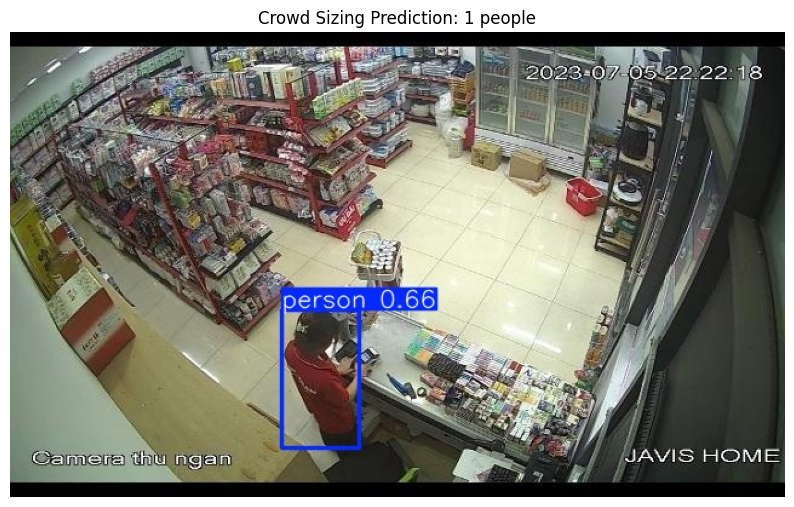

Detected people: 1
Annotated prediction saved to /content/people_detection/models/predictions/1310_person_jpg.rf.40e64470f37d814a9ebc19f5556a5616_pred.jpg


In [ ]:
sample_image = next((images_root / 'test').glob('*.*'), None)
assert sample_image is not None, 'No validation images found.'

result = model.predict(sample_image, conf=0.1, iou=0.5)[0]
person_mask = (result.boxes.cls.cpu().numpy() == 0)
person_count = int(person_mask.sum())
annotated = result.plot()  # BGR
output_path = pred_dir / f"{sample_image.stem}_pred.jpg"
cv2.imwrite(str(output_path), annotated)

# Load the annotated image
annotated_img_bgr = cv2.imread(str(output_path))

# Convert BGR to RGB for display with matplotlib
annotated_img_rgb = cv2.cvtColor(annotated_img_bgr, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(annotated_img_rgb)
plt.axis('off')
plt.title(f"Crowd Sizing Prediction: {person_count} people")
plt.show()

print(f"Detected people: {person_count}")
print(f"Annotated prediction saved to {output_path}")

## (Optional) Video inference with frame-level counts

In [ ]:
# Uncomment and set `video_path` to a local video to run inference.
# video_path = project_root / 'data' / 'raw' / 'your_video.mp4'
# output_video = pred_dir / 'people_count_video.mp4'
# csv_counts = pred_dir / 'people_count_per_frame.csv'
#
# cap = cv2.VideoCapture(str(video_path))
# fps = cap.get(cv2.CAP_PROP_FPS) or 25
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# writer = cv2.VideoWriter(str(output_video), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
#
# frame_counts = []
# idx = 0
# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
#     results = best_model(frame, conf=0.35, iou=0.5)[0]
#     count = int((results.boxes.cls.cpu().numpy() == 0).sum())
#     annotated = results.plot()
#     writer.write(annotated)
#     frame_counts.append({'frame': idx, 'people': count})
#     idx += 1
#
# cap.release()
# writer.release()
# pd.DataFrame(frame_counts).to_csv(csv_counts, index=False)
# print(f"Saved annotated video to {output_video}")
# print(f"Saved per-frame counts to {csv_counts}")
